In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import matplotlib.animation as animation
import json
import scipy
import os
from sklearn.mixture import GaussianMixture


import discrete_CRISPR_methods as ds
import discrete_CRISPR_sim_methods as ds2



In [2]:
def load_stuff(frame_cut = 0):
    params = json.load(open("_params.json"))
    sim_params = json.load(open("_sim_params.json"))
    try:
        frames_f = np.load("frames_f.npy")[frame_cut:]
        frames_n = np.load("frames_n.npy")[frame_cut:]
        frames_nh = np.load("frames_nh.npy")[frame_cut:]

    except IndexError:
        frames_f = np.load("frames_f.npy")
        frames_n = np.load("frames_n.npy")
        frames_nh = np.load("frames_nh.npy")
    return params, sim_params, frames_f, frames_n, frames_nh

In [3]:
def calculate_variance(single_frame, params, sim_params):
    x_range = sim_params["xdomain"] #Initialize the spaces
    dx = sim_params["dx"]

    x_linspace = np.arange(-x_range, x_range, dx)
    coordmap = np.meshgrid(x_linspace, x_linspace)
    radius = coordmap[0]**2 + coordmap[1]**2

    rqrd = 0
    for n, r2 in zip(np.ravel(single_frame), np.ravel(radius)):
        rqrd += n*r2
    
    return rqrd/np.sum(single_frame)

In [4]:
def get_Gaussian_Fit(frames_n, params, sim_params):
    frame_means = []
    frame_cov = []
    x_range = sim_params["xdomain"] #Initialize the spaces
    dx = sim_params["dx"]

    x_linspace = np.arange(-x_range, x_range, dx)
    coordmap = np.meshgrid(x_linspace, x_linspace)

    for single_frame in frames_n:
        point_data = []
        try:
            for nonzero_ind in np.argwhere(single_frame):
                n = single_frame[nonzero_ind[0], nonzero_ind[1]]
                x_ind = coordmap[1][nonzero_ind[0], nonzero_ind[1]]
                y_ind = coordmap[0][nonzero_ind[0], nonzero_ind[1]]
                for _ in range(n):
                    point_data.append([x_ind, y_ind])

            point_data = np.array(point_data).squeeze()

            gaussian_estimator = GaussianMixture(covariance_type="full", max_iter=20)
            gaussian_estimator.fit(point_data)

            covariances = gaussian_estimator.covariances_.squeeze()
            means = gaussian_estimator.means_.squeeze()

            frame_means.append(means)
            frame_cov.append(covariances)
            
        except ValueError:
            continue

    frame_means = np.array(frame_means).squeeze()
    return frame_means, frame_cov

In [5]:
def make_ellipse(means, covariances, color = "navy"):
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(
        means, v[0], v[1], 180 + angle, color=color
    )
    return ell

In [6]:
foldername = '/media/homes/thisiszhi/code/data/ParamsSweep/'
subfolders = [ f.path for f in os.scandir(foldername) if f.is_dir() ]
frame_cut = 0

/media/homes/thisiszhi/code/data/ParamsSweep/Simulation#7


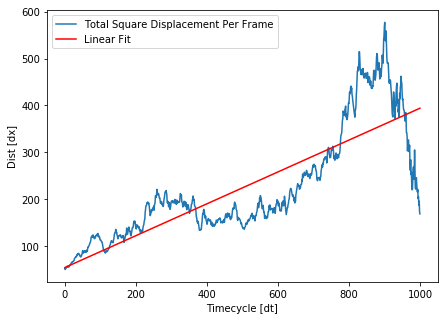

In [25]:
current_folder = subfolders[0]
print(current_folder)
os.chdir(current_folder)
params, sim_params, frames_f, frames_n, frames_nh = load_stuff(frame_cut)

frames_nvar = []
for frame in frames_n:
    frames_nvar.append(calculate_variance(frame, params, sim_params))

frames_nvar = np.array(frames_nvar).squeeze()
avg_var = np.mean(frames_nvar)
var_var = np.var(frames_nvar)
err_var = var_var

plt.figure(figsize=[7, 5])
# plt.title("$<r^2(t)>$")
plt.ylabel("Dist [dx]")
plt.xlabel("Timecycle [dt]")
plt.plot(frames_nvar, label="Total Square Displacement Per Frame")

x = np.arange(0,len(frames_nvar),1)
fit = np.polyfit(x, frames_nvar, 1)
plt.plot(x, np.polyval(fit, x), color="r", label = "Linear Fit")
plt.legend()
var_diff = np.var(np.polyval(fit, x)-frames_nvar)
err_diff = var_diff

/media/homes/thisiszhi/code/data/ParamsSweep/Simulation#7


Text(0, 0.5, 'Reccurence [Normalized]')

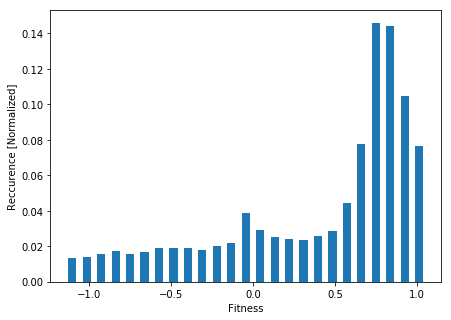

In [27]:
current_folder = subfolders[0]
print(current_folder)
os.chdir(current_folder)
params, sim_params, frames_f, frames_n, frames_nh = load_stuff(frame_cut)

frame = ma.array(frames_f[0], mask = (frames_n[0] == 0)).compressed()
height, bins = np.histogram(frame, 25, range = (-1.1, 1.1))
cummulative = np.zeros(height.shape)

frame_avg = []
frame_var = []

for single_f, single_n in zip(frames_f, frames_n):
    ma_f = (single_n == 0)

    if np.sum(ma_f) == 0:
        print("population Death")
        break

    frame = ma.array(single_f, mask = ma_f).compressed()
    frame_avg.append(np.mean(frame))
    frame_var.append(np.var(frame))
    height, _ = np.histogram(frame, 25, range = (-1.1, 1.1))
    cummulative += height

norm_height = cummulative/np.sum(cummulative)

plt.figure(figsize = [7, 5])
plt.bar(bins[:-1], norm_height, width = 0.05)
plt.xlabel("Fitness")
plt.ylabel("Reccurence [Normalized]")
# plt.title("Fitness Distribution")

/media/homes/thisiszhi/code/data/ParamsSweep/Simulation#7


(-15, 15)

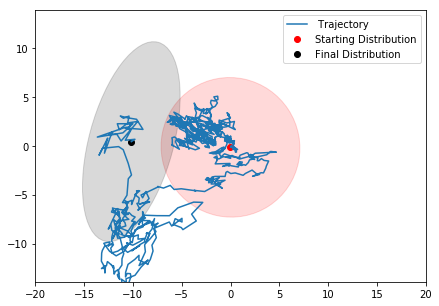

In [28]:
from cProfile import label
current_folder = subfolders[0]
print(current_folder)
os.chdir(current_folder)
params, sim_params, frames_f, frames_n, frames_nh = load_stuff(frame_cut)
frames_means, frames_cov = get_Gaussian_Fit(frames_n, params, sim_params)

fig, ax = plt.subplots(figsize = [7, 5])
ax.plot(frames_means[:,0], frames_means[:,1], label = " Trajectory")
# plt.title("Trajectory of Phage Distribution")
# ax.imshow(frames_n[0], cmap="Greys")

ax.scatter(frames_means[0, 0], frames_means[0, 1], color = 'red', label = "Starting Distribution")
ell1 = make_ellipse(frames_means[0], frames_cov[0], 'red')
ell1.set_clip_box(ax.bbox)
ell1.set_alpha(0.15)
ax.add_patch(ell1)
ax.set_aspect("equal", "datalim")

ax.scatter(frames_means[-1, 0], frames_means[-1, 1], color = 'black', label = "Final Distribution")
ell2 = make_ellipse(frames_means[-1], frames_cov[-1], 'black')
ell2.set_clip_box(ax.bbox)
ell2.set_alpha(0.15)
ax.add_patch(ell2)
ax.set_aspect("equal", "datalim")

plt_bd = sim_params["xdomain"]
plt.legend()
plt.xlim(-20, 20)
plt.ylim(-15, 15)


/media/homes/thisiszhi/code/data/ParamsSweep/Simulation#7


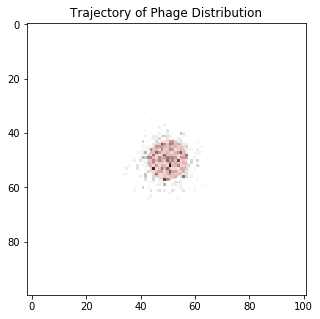

In [29]:
current_folder = subfolders[0]
print(current_folder)
os.chdir(current_folder)
params, sim_params, frames_f, frames_n, frames_nh = load_stuff()
frames_means, frames_cov = get_Gaussian_Fit(frames_n, params, sim_params)

fig, ax = plt.subplots(figsize = [5, 5])
plt.title("Trajectory of Phage Distribution")
ax.imshow(frames_n[0], cmap="Greys")


ell1 = make_ellipse(frames_means[0]+50, frames_cov[0], 'red')
ell1.set_clip_box(ax.bbox)
ell1.set_alpha(0.15)
ax.add_patch(ell1)
ax.set_aspect("equal", "datalim")

In [30]:
foldername = '/media/homes/thisiszhi/code/data/Params10x/'
subfolders = [ f.path for f in os.scandir(foldername) if f.is_dir() ]
sim_length = (sim_params["tf"]-sim_params["t0"])/sim_params["dt"]

N_folder = np.zeros([len(subfolders), int(sim_length)])
for id, current_folder in enumerate(subfolders):
    print(current_folder)
    os.chdir(current_folder)
    params, sim_params, frames_f, frames_n, frames_nh = load_stuff()

    for i, single_n in enumerate(frames_n):
        n = np.sum(single_n)
        N_folder[id, i] = n

xdomain = np.arange(0, sim_length)
means = np.mean(N_folder, 0)
variances = np.var(N_folder, 0)

# plt.figure()
# plt.plot(N)
# plt.title("Number of active phage over time")
# plt.ylabel("Population")
# plt.xlabel("Frame number")

/media/homes/thisiszhi/code/data/Params10x/Simulation#7
/media/homes/thisiszhi/code/data/Params10x/Simulation#3
/media/homes/thisiszhi/code/data/Params10x/Simulation#5
/media/homes/thisiszhi/code/data/Params10x/Simulation#1
/media/homes/thisiszhi/code/data/Params10x/Simulation#0
/media/homes/thisiszhi/code/data/Params10x/Simulation#9
/media/homes/thisiszhi/code/data/Params10x/Simulation#8
/media/homes/thisiszhi/code/data/Params10x/Simulation#2
/media/homes/thisiszhi/code/data/Params10x/Simulation#6
/media/homes/thisiszhi/code/data/Params10x/Simulation#4


Text(0.5, 0, 'Frame Number')

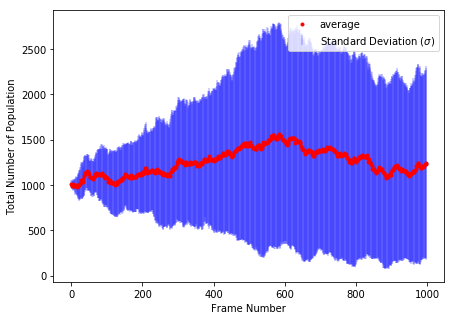

In [43]:
plt.figure(figsize = [7, 5])
plt.errorbar(xdomain[0:-1:1], means[0:-1:1], np.sqrt(variances)[0:-1:1], color = "b", fmt = "none", label = "Standard Deviation $(\sigma)$", alpha = 0.25)
plt.plot(xdomain[0:-1:2], means[0:-1:2], "r.", label = "average")
# plt.title("Variance of Simulation Results")
plt.ylabel("Total Number of Population")
plt.legend()
plt.xlabel("Frame Number")

In [45]:
foldername = '/media/homes/thisiszhi/code/data/ParamsSweepNp/'
subfolders = [ f.path for f in os.scandir(foldername) if f.is_dir() ]

x_variable = 'Np'
y_variable = "avg_f"
y_variable_err = "var_f"

y = []
y_err = []
x = []

for current_folder in subfolders:
    os.chdir(current_folder)

    results = json.load(open("_results.json"))
    params = json.load(open("_params.json"))

    y.append(results[y_variable])
    y_err.append(results[y_variable_err])
    x.append(params[x_variable])

y = np.array(y).squeeze()
x = np.array(x).squeeze()
y_err = np.array(y_err).squeeze()

In [46]:
foldername = '/media/homes/thisiszhi/code/data/ParamsSweepNpLongM100/'
subfolders = [ f.path for f in os.scandir(foldername) if f.is_dir() ]

x_variable = 'Np'
y_variable = "avg_f"
y_variable_err = "var_f"

y2 = []
y_err2 = []
x2 = []

for current_folder in subfolders:
    os.chdir(current_folder)

    results = json.load(open("_results.json"))
    params = json.load(open("_params.json"))

    y2.append(results[y_variable])
    y_err2.append(results[y_variable_err])
    x2.append(params[x_variable])

y2 = np.array(y2).squeeze()
x2 = np.array(x2).squeeze()
y_err2 = np.array(y_err2).squeeze()

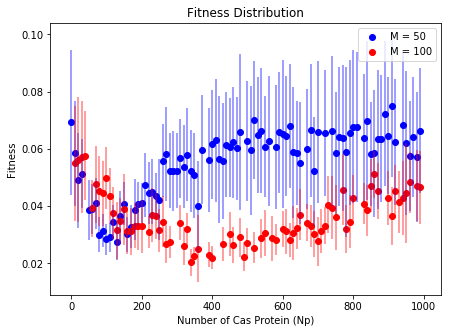

In [49]:
plt.figure(figsize = [7, 5])
plt.title("Fitness Distribution")
plt.ylabel('Fitness')
plt.xlabel('Number of Cas Protein (Np)')
# plt.scatter(x, y, color = "k")
plt.errorbar(x, y, y_err, color = "b", fmt = "none", alpha = 0.5,)
plt.scatter(x, y, color = 'b', label = "M = 50")
# plt.fill_between(x, y+y_err, y-y_err)
plt.errorbar(x2, y2, y_err2, color = "r", fmt = "none", alpha = 0.5)
plt.scatter(x2, y2, color = 'r', label = "M = 100")
plt.legend()
plt.show()

In [10]:
foldername = '/media/homes/thisiszhi/code/data/ParamsSweepMLong/'
subfolders = [ f.path for f in os.scandir(foldername) if f.is_dir() ]

x_variable = 'M'
y_variable = "avg_f"
y_variable_err = "var_f"

y2 = []
y_err2 = []
x2 = []

for current_folder in subfolders:
    os.chdir(current_folder)

    results = json.load(open("_results.json"))
    params = json.load(open("_params.json"))

    y2.append(results[y_variable])
    y_err2.append(results[y_variable_err])
    x2.append(params[x_variable])

y2 = np.array(y2).squeeze()
x2 = np.array(x2).squeeze()
y_err2 = np.array(y_err2).squeeze()

Text(0.5, 0, 'Number of Cas Protein, Scaled by Fitness {${N_p / f(N_p)}$}')

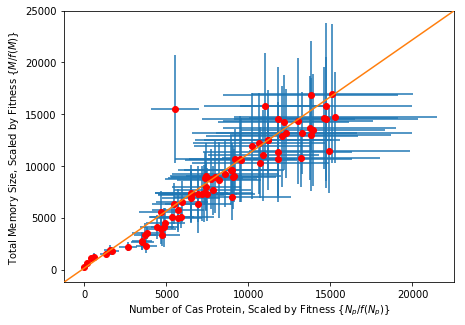

In [16]:
fig, axs = plt.subplots(figsize = [7, 5])
new_x = x[1:]/y[1:] 
new_y = x2/y2 
new_xerr = y_err[1:]*new_x/y[1:]
new_yerr = y_err2*new_y/y2
axs.errorbar(new_x, new_y, yerr= new_yerr, xerr=new_xerr, fmt= "none")
axs.plot([0,1],[0,1], transform=axs.transAxes, zorder = 10)
plt.scatter(x[1:]/y[1:], x2/y2, color = 'red', zorder = 5)
# plt.title("Agreement between Memory Size and Number of Cas Protein")
plt.ylabel("Total Memory Size, Scaled by Fitness {$M/f(M)$}")
plt.xlabel("Number of Cas Protein, Scaled by Fitness {${N_p / f(N_p)}$}")

In [22]:
foldername = '/media/homes/thisiszhi/code/data/ParamsSweepCrossLong2/'
subfolders = [ f.path for f in os.scandir(foldername) if f.is_dir() ]
folders = foldername + 'Simulation#'
subfolders2 = [folders + str(i) for i, _ in enumerate(subfolders)]

x_variable = 'r'
y_variable = "avg_grp_vel"
y_variable_err = "var_grp_vel"

y = []
y_err = []
x = []

for current_folder in subfolders2:
    os.chdir(current_folder)

    results = json.load(open("_results.json"))
    params = json.load(open("_params.json"))

    y.append(results[y_variable])
    y_err.append(results[y_variable_err])
    x.append(params[x_variable])

y = np.array(y).squeeze()
x = np.array(x).squeeze()
y_err = np.sqrt(np.array(y_err).squeeze())/10

In [118]:
foldername = '/media/homes/thisiszhi/code/data/ParamsSweepCrossLongM100/'
subfolders = [ f.path for f in os.scandir(foldername) if f.is_dir() ]
folders = foldername + 'Simulation#'
subfolders2 = [folders + str(i) for i, _ in enumerate(subfolders)]

x_variable = 'r'
y_variable = "avg_grp_vel"
y_variable_err = "var_grp_vel"

y2 = []
y_err2 = []
x2 = []

for current_folder in subfolders2:
    os.chdir(current_folder)

    results = json.load(open("_results.json"))
    params = json.load(open("_params.json"))

    y2.append(results[y_variable])
    y_err2.append(results[y_variable_err])
    x2.append(params[x_variable])

y2 = np.array(y2).squeeze()
x2 = np.array(x2).squeeze()
y_err2 = np.sqrt(np.array(y_err2).squeeze())/10

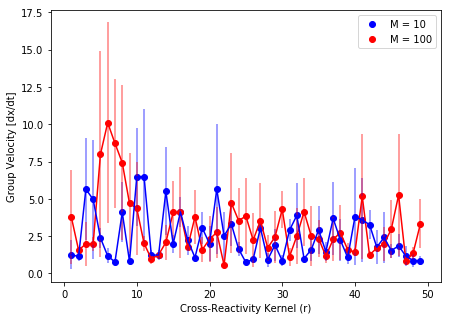

In [24]:
plt.figure(figsize = [7, 5])
# plt.title("Phage Fitness Distribution")
plt.ylabel('Group Velocity [dx/dt]')
plt.xlabel('Cross-Reactivity Kernel (r)')
# plt.scatter(x, y, color = "k")
plt.errorbar(x, y, y_err, color = "b", fmt = "none", alpha = 0.5,)
plt.scatter(x, y, color = 'b', label = "M = 10")
# plt.fill_between(x, y+y_err, y-y_err)
plt.errorbar(x2, y2, y_err2, color = "r", fmt = "none", alpha = 0.5)
plt.scatter(x2, y2, color = 'r', label = "M = 100")
plt.plot(x2, y2, color = 'r')
plt.plot(x, y, color = 'b')
# plt.yscale("log")
plt.legend()
plt.show()

No handles with labels found to put in legend.


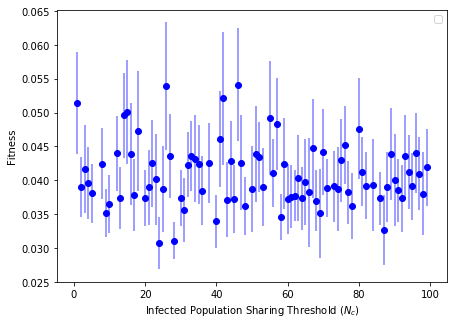

In [118]:
foldername = '/media/homes/thisiszhi/code/data/ParamsSweepNcLong/'
subfolders = [ f.path for f in os.scandir(foldername) if f.is_dir() ]
folders = foldername + 'Simulation#'
subfolders2 = [folders + str(i) for i, _ in enumerate(subfolders)]

x_variable = 'Nc'
y_variable = "avg_f"
y_variable_err = "var_f"

y = []
y_err = []
x = []

for current_folder in subfolders:
    os.chdir(current_folder)

    results = json.load(open("_results.json"))
    params = json.load(open("_params.json"))

    y.append(results[y_variable])
    y_err.append(results[y_variable_err])
    x.append(params[x_variable])

y = np.array(y).squeeze()
x = np.array(x).squeeze()
y_err = np.array(y_err).squeeze()

plt.figure(figsize = [7, 5])
# plt.title("Fitness Distribution")
plt.ylabel('Fitness')
plt.xlabel('Infected Population Sharing Threshold $(N_c)$')
plt.errorbar(x, y, y_err, color = "b", fmt = "none", alpha = 0.5,)
plt.scatter(x, y, color = 'b')
plt.legend()
plt.show()

No handles with labels found to put in legend.


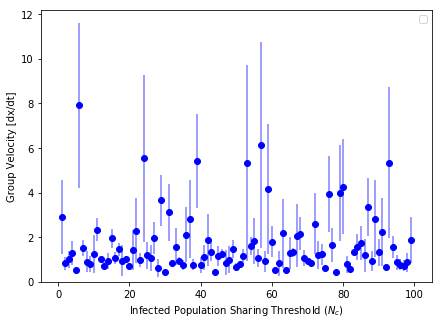

In [17]:
foldername = '/media/homes/thisiszhi/code/data/ParamsSweepNcLong/'
folders = foldername + 'Simulation#'
subfolders = [ f.path for f in os.scandir(foldername) if f.is_dir() ]
subfolders2 = [folders + str(i) for i, _ in enumerate(subfolders)]

x_variable = 'Nc'
y_variable = "avg_grp_vel"
y_variable_err = "var_grp_vel"

y = []
y_err = []
x = []

for current_folder in subfolders2:
    os.chdir(current_folder)

    results = json.load(open("_results.json"))
    params = json.load(open("_params.json"))

    y.append(results[y_variable])
    y_err.append(results[y_variable_err])
    x.append(params[x_variable])

y = np.array(y).squeeze()
x = np.array(x).squeeze()
y_err = np.array(y_err).squeeze()

plt.figure(figsize = [7, 5])
# plt.title("Fitness Distribution")
plt.ylabel('Group Velocity [dx/dt]')
plt.xlabel('Infected Population Sharing Threshold $(N_c)$')
plt.errorbar(x, y, np.sqrt(y_err)/10, color = "b", fmt = "none", alpha = 0.5,)
plt.scatter(x, y, color = 'b')
plt.ylim(bottom = 0)
plt.legend()
plt.show()

In [6]:
foldername = '/media/homes/thisiszhi/code/data/ParamsSweepCrossLong2/'
folders = foldername + 'Simulation#'
subfolders = [ f.path for f in os.scandir(foldername) if f.is_dir() ]
subfolders2 = [folders + str(i) for i, _ in enumerate(subfolders)]

In [7]:
x_variable = 'r'
y_variable = "avg_grp_vel"
y_variable_err = "var_grp_vel"

y = []
y_err = []
x = []

for current_folder in subfolders2:
    os.chdir(current_folder)

    results = json.load(open("_results.json"))
    params = json.load(open("_params.json"))

    y.append(results[y_variable])
    y_err.append(results[y_variable_err])
    x.append(params[x_variable])

y = np.array(y).squeeze()
x = np.array(x).squeeze()
y_err = np.array(y_err).squeeze()



In [8]:
x_variable = 'r'
y_variable = "diff_coeff"
y_variable_err = "var_diff_coeff"

y_var_diff_coeff = []
y_diff_coeff = []
y_avg_N = []
y_var_N = []
x2 = []
y_s = []

for current_folder in subfolders2:
    os.chdir(current_folder)
    params, sim_params, frames_f, frames_n, frames_nh = load_stuff()

    results = json.load(open("_results.json"))
    params = json.load(open("_params.json"))

    diff_coeff = results['diff_coeff']
    if np.isnan(diff_coeff) or (diff_coeff <= 0):
        continue

    N = np.sum(frames_n, (1, 2))
    
    s = (params["M"]/params["r"])*(np.power(params["R0"], (1/params["M"]))-1)

    y_avg_N.append(np.mean(N))
    y_var_N.append(np.var(N))

    y_diff_coeff.append(diff_coeff)
    y_var_diff_coeff.append(results[y_variable_err])

    x2.append(params[x_variable])
    y_s.append(s)

y_diff_coeff = np.array(y_diff_coeff).squeeze()
y_var_diff_coeff = np.array(y_var_diff_coeff).squeeze()
y_avg_N = np.array(y_avg_N).squeeze()
y_var_N = np.array(y_var_N).squeeze()
x2 = np.array(x2).squeeze()
y_s = np.array(y_s).squeeze()

In [9]:
anti_log = np.cbrt(y_diff_coeff*np.power(y_s, 2))*y_avg_N
denom = np.power(3, 2/3)*y_avg_N*np.power(np.log(anti_log), 2/3)
der_wrt_N = np.divide(2*np.power(y_diff_coeff, 2)*y_s, denom)

In [10]:
anti_log = np.cbrt(y_diff_coeff*np.power(y_s, 2))*y_avg_N
nume = y_s*(36*np.log(anti_log)+2)*y_diff_coeff
denom = np.power(3, 5/3)*np.power(np.log(anti_log), 2/3)
der_wrt_D = np.divide(nume, denom)

In [11]:
sq_err = np.power(der_wrt_N, 2)*y_var_N + np.power(der_wrt_D,2)*y_var_diff_coeff

In [12]:
sec_term = np.cbrt(24*np.log(y_avg_N*np.cbrt(y_diff_coeff*np.power(y_s, 2))))
y_calc_grp_speed = np.cbrt(np.power(y_diff_coeff, 2)*y_s)*sec_term

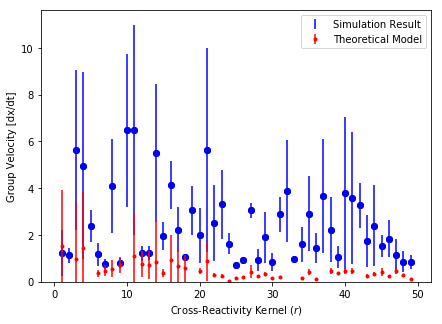

In [13]:
plt.figure(figsize = [7, 5])
# plt.title("Fitness Distribution")
plt.ylabel('Group Velocity [dx/dt]')
plt.xlabel('Cross-Reactivity Kernel $(r)$')
plt.errorbar(x, y, np.sqrt(y_err)/10, color = "b", fmt = "none", alpha = 1,label = "Simulation Result")
plt.scatter(x, y, color = 'b')
plt.scatter(x, y, color = 'b')
plt.errorbar(x2, y_calc_grp_speed, yerr = np.sqrt(sq_err)/10, fmt= 'r.', label = "Theoretical Model")
# plt.yscale("log")
plt.ylim(bottom = 0)
plt.legend()
plt.show()

In [14]:
mask = ~np.in1d(x, x2)
y_theo_grp_speed = np.ma.array(y, mask = mask).compressed() 
y_var_theo_grp_speed = np.ma.array(y_err, mask = mask).compressed() 
agr_grp_speed = y_theo_grp_speed/y_calc_grp_speed
yerr = (agr_grp_speed/10)*(np.sqrt(y_var_theo_grp_speed)/y_theo_grp_speed + np.sqrt(sq_err)/y_calc_grp_speed)

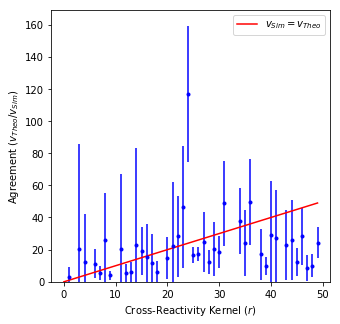

In [18]:
plt.figure(figsize = [5, 5])
# plt.title("Fitness Distribution")
plt.ylabel('Agreement $(v_{Theo}/v_{Sim})$')
plt.xlabel('Cross-Reactivity Kernel $(r)$')
plt.errorbar(x2, 3.5*agr_grp_speed, yerr = 3.5*yerr, fmt = 'b.')
# plt.plot(np.arange(0,50), (1/3.5)*np.arange(0, 50), color = 'orange', label = "$v_{Sim}=v_{Theo}$")
plt.plot(np.arange(0,50), np.arange(0, 50), color = 'red', label = "$v_{Sim}=v_{Theo}$")
# plt.yscale("log")
plt.ylim(bottom = 0)
plt.legend()
plt.show()

In [6]:
foldername = '/media/homes/thisiszhi/code/data/ParamsSweepNpNoCtrl/'
folders = foldername + 'Simulation#'
subfolders = [ f.path for f in os.scandir(foldername) if f.is_dir() ]
subfolders2 = [folders + str(i) for i, _ in enumerate(subfolders)]

x_variable = 'Np'
y_variable = "diff_coeff"
y_variable_err = "var_diff_coeff"

y = []
y_err = []
x = []

for current_folder in subfolders2:
    os.chdir(current_folder)

    results = json.load(open("_results.json"))
    params = json.load(open("_params.json"))

    y.append(results[y_variable])
    y_err.append(results[y_variable_err])
    x.append(params[x_variable])

y = np.array(y).squeeze()
x = np.array(x).squeeze()
y_err = np.array(y_err).squeeze()

In [7]:
foldername = '/media/homes/thisiszhi/code/data/ParamsSweepNp/'
folders = foldername + 'Simulation#'
subfolders = [ f.path for f in os.scandir(foldername) if f.is_dir() ]
subfolders2 = [folders + str(i) for i, _ in enumerate(subfolders)]

y_variable = 'diff_coeff'

y1 = []
y1_err = []
x1 = []

for current_folder in subfolders2:
    os.chdir(current_folder)

    results = json.load(open("_results.json"))
    params = json.load(open("_params.json"))

    y1.append(results[y_variable])
    y1_err.append(results[y_variable_err])
    x1.append(params[x_variable])

# y1 = np.ma.masked_array(y1, mask = np.isnan(y1))
# y1_err = np.ma.masked_array(y1_err, mask = np.isnan(y1))
# y1 = np.mean(y1)
# y1_err = np.mean(y1_err)

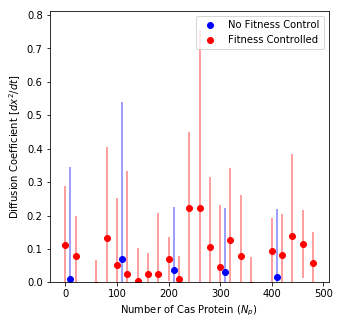

In [8]:
plt.figure(figsize = [5, 5])
# plt.title("Fitness Distribution")
plt.ylabel('Diffusion Coefficient $[dx^2/dt]$')
plt.xlabel('Number of Cas Protein $(N_p)$')
plt.scatter(x, y, color = 'b', label = "No Fitness Control")
plt.errorbar(x, y, np.sqrt(y_err)/20, color = "b", fmt = "none", alpha = 0.5,)
plt.errorbar(x1[0:50:2], y1[0:50:2], np.sqrt(y1_err[0:50:2])/100, color = "r", fmt = "none", alpha = 0.5,)
plt.scatter(x1[0:50:2], y1[0:50:2], color = 'r', label = "Fitness Controlled")
plt.ylim(bottom = 0)
plt.legend()
plt.show()